# Neural Graphics - From Meshes to Neural Shapes
Lecture for the AI & ML Course, Applied Computer Science & Artificial Intelligence

**Note:** run this notebook with the GPU enabled.

dorazio@di.uniroma1.it

# Imports

In [ ]:
!pip install trimesh mesh_to_sdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.6/694.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyopengl: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745192 sha256=d4179b6f9abf59af392d86a52b720ed6e5113572b3a0508d53e1b88d712777db
  Stored in directory: /root/.cache/pip/wheels/a1/3c/d2/1f9533f908d86176637521e533c6cdb2d4e48b59003b5c3f19
Successfully built pyopengl
  Attempting uninstall: pyopengl
    Found existing installation: PyOpenGL 3.1.7
    Uninstalling PyOpenGL-3.1.7:
      Successfully uninstalled PyOpenGL-3.1.7


Libraries import

In [ ]:
import torch
import argparse
import numpy as np
import trimesh
import mesh_to_sdf as mts
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
DEVICE = "cuda:0"

# Basics of Computer Graphics

## Representing 3D shapes

### Meshes

<img src="http://tiborstanko.sk/assets/cescg2014/bunny_weights/bunny_3000F_00.png" width="250">

Meshes represent shapes as collections of vertices (points in 3D space) connected by edges to form polygons. Mathematically, a mesh can be represented as a pair, $M = (V, E)$, where:
    
- $V = {(x_i, y_i, z_i)}$ is a set of vertices, with each vertex denoted by its coordinates.
- $E ⊆ V x V$ is a set of edges, representing connections between vertices.



### Point Clouds

<img src="https://www.researchgate.net/profile/Manuel-Oliveira-4/publication/228945815/figure/fig3/AS:669419906822166@1536613551997/Bunny-models-reconstructed-with-our-algorithm-a-Closed-surface-combining-surface-and_Q640.jpg" width="250">

Point clouds are unordered collections of 3D points, $P = {(x_i, y_i, z_i)}$, representing the surface of a shape. They lack explicit connectivity information between points.

They are mostly used in Deep Learning pipeline as a result of a pre-processing step applied to meshes.



### Implicit Representations

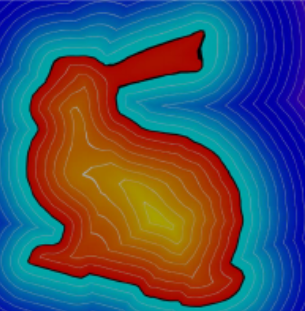

Implicit representations define a shape through a function that determines whether a point lies inside or outside the shape. A common example is the Signed Distance Function (SDF):

$$
SDF(\vec{p}) = d(x, S)
$$

where:

- $SDF(\vec{p})$ is the signed distance from point $x$ to the surface $S$ of the shape.
- $d(\vec{p}, S)$ is the Euclidean distance function.

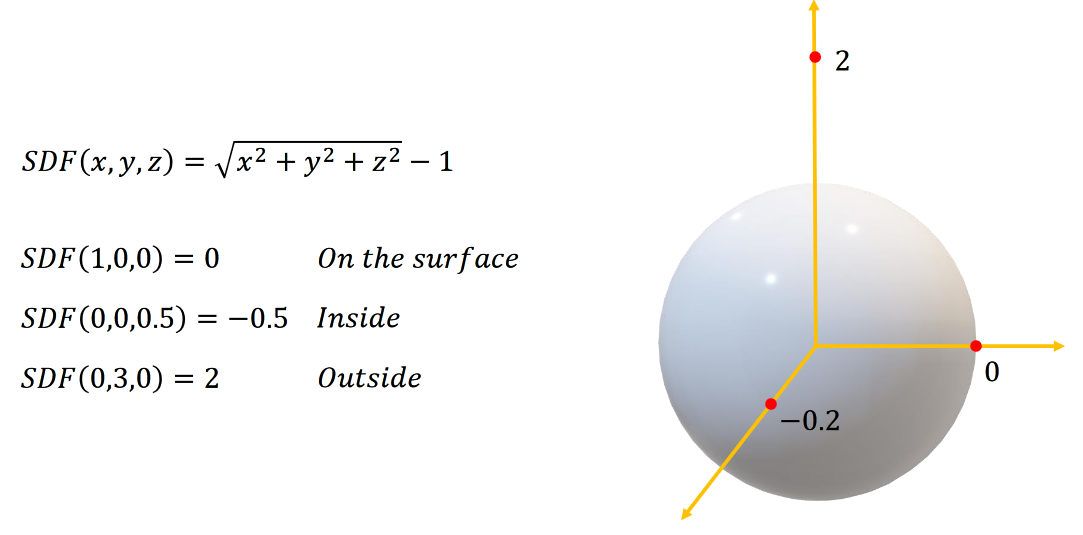

We can distinguish three cases:

- $SDF(\vec{p}) < 0$ indicates $x$ is inside the shape.
- $SDF(\vec{p}) = 0$ indicates $x$ is on the surface.
- $SDF(\vec{p}) > 0$ indicates $x$ is outside the shape.

## Rendering: transforming 3D informations in a 2D image

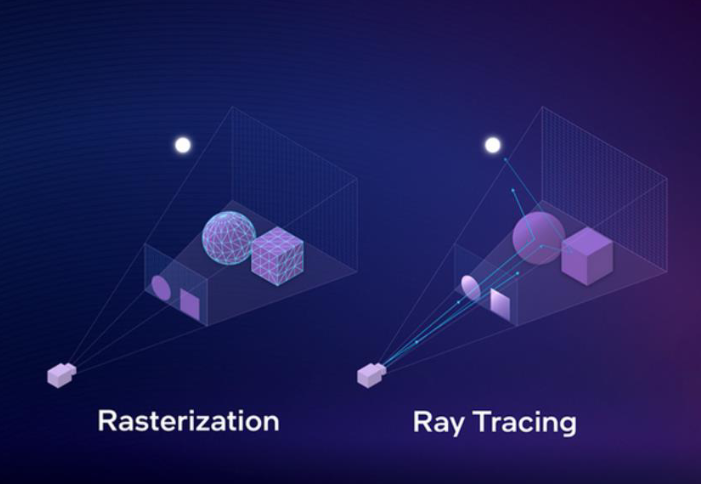

Rendering techniques translate 3D representations into images:

* **Rasterization:** Rasterization projects 3D objects onto a 2D image plane, filling pixels based on object attributes and visibility calculations. Physical phenomena, like shadows and reflections, are not correct, but rather an approximation. Mathematically, this involves transformations:
    * **World to camera:** Transforms object vertices from world space to camera space for viewing.
    * **Camera to clip:** Projects camera-space coordinates onto a normalized device coordinate (NDC) space suitable for clipping against the view frustum.
    * **Clipping:** Eliminates objects outside the camera's view frustum.
    * **Perspective division:** Converts NDC coordinates to homogeneous clip space for perspective correction.
    * **Viewport transformation:** Maps clip space coordinates to the final pixel coordinates on the image plane.

* **Ray tracing:** Ray tracing is a family of algorithms that simulate the physical behavior of light to generate photorealistic images, but it's very slow to compute. Recent advances in both hardware (e.g., RTX graphics cards) and algorithms are enabling real-time ray tracing. It recursively traces light paths from the camera through the scene, calculating interactions with objects defined mathematically using functions like:
    * Surface reflectance properties (e.g., Bidirectional Reflectance Distribution Function - BRDF)
    * Material properties (e.g., absorption coefficient)
    * Light source properties (e.g., intensity distribution)





Depending on the data structure, there exists different implementation of the ray tracing algorithm.

For meshes, ray tracing is applied in the form of [**Path Tracing**](https://www.youtube.com/watch?v=frLwRLS_ZR0), while SDFs are rendered using [**Ray Marching**](https://www.alanzucconi.com/2016/07/01/raymarching/), which is a simplified form, because detecting an intersection with SDFs is trivial.

**Rasterization** is widely used in videogames since the early 3D era in the 1990s, because we need each frame to be displayed at least in 1/30 of a second.

**Path tracing** is extremely computationally expensive and, until the recent years, it required *hours* to display a single frame. It is widespread in movie production and architectural visualization, because of the way it captures photorealistic (and physically accurate) light phenomena such as reflections and shadows.

---
**From hours to milliseconds:**

When you hear about a modern video game supporting real-time path tracing, take a moment to appreciate what a monumental leap this represents for the graphics industry.

# Neural graphics

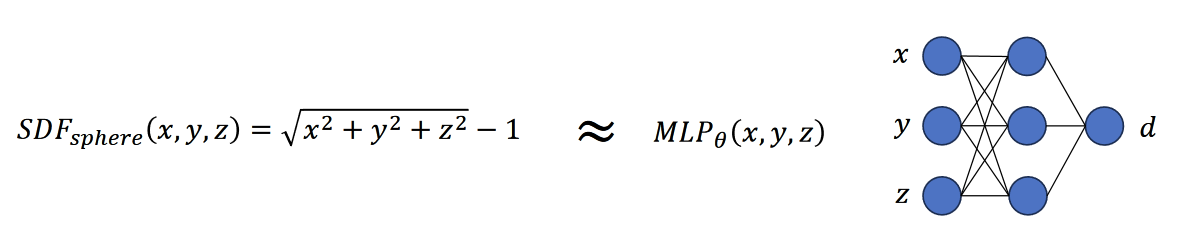




Neural graphics leverages deep learning to represent and manipulate 3D shapes.

* **SDFs as MLPs:** We can represent an SDF using a Multi-Layer Perceptron (MLP), a neural network that learns a function mapping a 3D point $\vec{p} = (x,y,z)$ to a signed distance $d = SDF(\vec{p})$. The MLP takes $\vec{p}$ as input and predicts the distance through hidden layers and activation functions.



## Increasing the details: Fourier features

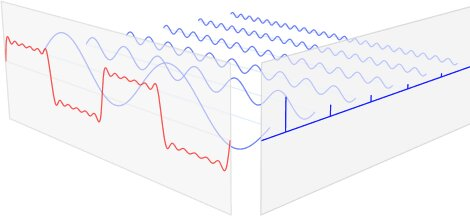


* **Learning the high frequencies:** Deep Neural Networks are excellent at **generalization**. On the other hand, it also means not considering enough fine details. To address this problem, inside the model we force a decomposition of the features into multiple frequencies, forcing the model to consider each fundamental signal, including the high-frequency ones. **High frequencies = fine details**.

* **Fourier features:** The Fourier transform effectively decomposes a signal into its sinusoidal components, as you can see in the image above. This approach comes from [this](https://arxiv.org/abs/2006.10739) paper. Mathematically, for a 3D point $\vec{p} = (x, y, z)$, the Fourier feature vector, denoted as $φ(x)$, is defined as:


$$
φ(x) = [cos(ω_1x), sin(ω_1x), ..., cos(ω_dx), sin(ω_dx)]^T
$$



More details further in the notebook.

# Putting pieces together

So far, we covered the concepts of
* **Implicit Functions**, specifically Signed Distance Functions (SDFs), that represents a 3D shape by describing if a point is inside, outside, or if is lying on the boundary.

* **Neural Implicit Functions**: since SDFs are just mathematical functions, we can train a neural network to learn an approximation of it.

* **Spectral decomposition**: if we transform our input data into its decomposition made of sine waves, we force our neural network to learn the high frequencies, which are usually the hardest to discover (neural networks prefer generalization over little details)

Let's now put every piece together to train our neural bunny!

## Source mesh

We will use the Stanford Bunny, a famous test shape from the Stanford University.

In [ ]:
!git clone https://github.com/AntonioDOrazio/low-poly-bunny

Cloning into 'low-poly-bunny'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 124.46 KiB | 10.37 MiB/s, done.


In [ ]:
!ls low-poly-bunny

bunny2.obj


In [ ]:
dir = "/content/low-poly-bunny/"
MESH = dir + "bunny2.obj"

## The model

We define a neural network that takes a 3D point $\vec{p}$ as input and predicts the signed distance $SDF(\vec{p})$ to the surface of the target shape. The network architecture will use:

* Fourier features to compute the spectral decomposition of the input;
* Multiple hidden layers, like a traditional MLP;
* An output layer with a single neuron predicting the signed distance.

In [ ]:
OUTPUT = "output"
STEPS = 600000

In [ ]:
MODEL_SIZE = 'small' # @param ["small", "normal", "big"]
STYLE = 'smooth' # @param ["smooth", "sharp"]

## Fourier features layer

In this section, you will implement a custom PyTorch module that takes the input dataset, $P = \{\vec{p_1}, ... \vec{p_n}\}$ and extracts the spectral decomposition using an approach based on the Fourier transform.

Let's recall the terminology to adapt it to our domain.

$$
φ(x) = [cos(ω_1x), sin(ω_1x), ..., cos(ω_dx), sin(ω_dx)]^T
$$

We need to be careful of two things:
1. The sampled points range between $-1$ and $1$, but trigonometric functions expect an **angle** as input. We make them happy by multiplying the points by $2\pi$, so that the input is in range $(-2\pi, 2\pi)$

$$
φ(x) = [cos(2\pi\alpha_1x), sin(2\pi\alpha_1x), ..., cos(2\pi\alpha_dx), sin(2\pi\alpha_dx)]^T
$$

2. We want to differentiate the learned frequencies $w_i$. The proposed approach is to include a random variable $a_i$ inside the product, forcing the model to learn different weights. Our final decomposition will look like this:

$$
φ(x) = [cos(2\pi a_1 \alpha_1x), sin(2\pi a_1 \alpha_1x), ..., cos(2\pi a_d \alpha_dx), sin(2\pi a_d \alpha_dx)]^T
$$

Where:

- $a_1, ... a_d$ are random numbers;
- $\alpha_1, ... \alpha_d$ are learnable PyTorch parameters;
- $d$ is `embedding_size // 2`.

**Question**:
why is `d = embedding_size // 2` and not `d = embedding_size`?



In [ ]:
#@title #### Answer
'''
  We use each a_i two times, for both the sine and the cosine waves. Therefore, our final embedding for the data will be twice the size.
'''

#### **Exercise:**
Implement the `FourierFeatures` layer following the indications above.

In [ ]:
class FourierFeatures(torch.nn.Module):
    def __init__(self, embedding_size=256):
        # your code here
        pass

    def forward(self, x):
        # your code here
        pass

In [ ]:
#@title #### Solution

class FourierFeatures(torch.nn.Module):
    def __init__(self, embedding_size=256):
        super(FourierFeatures, self).__init__()
        self.fourier_mappings = torch.randn(3, embedding_size // 2).to(DEVICE)
        self.alpha = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):
        x = torch.matmul(2 * torch.pi * x, self.fourier_mappings * self.alpha)
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

## Neural SDF Network

Now that we implemented the Fourier Features decomposition layer, we have all the building blocks we need to instantiate our Neural SDF model.

Our model will be composed by:
- A `FourierFeatures` layer, with the desired `embedding_size`
- A total of `hidden_layers` of intermediate layers. We want all of them with `in_features=size`, `out_features=size`
- A final output layer, which outputs our scalar value representing the distance.

After each linear layer, add the activation function specified from the constructor, `ReLU` or `Sigmoid`.

#### **Exercise:**


Implement the Neural SDF model.

In [ ]:
class SDFDNN(torch.nn.Module):
    def __init__(
        self,
        size,
        embedding_size,
        hidden_layers=0,
        activation_type="relu",
    ):
        super(SDFDNN, self).__init__()

        # your code here
        pass

    def forward(self, x):
        # your code here
        pass

In [ ]:
#@title #### Solution
class SDFDNN(torch.nn.Module):
    def __init__(
        self,
        size,
        embedding_size,
        hidden_layers=0,
        activation_type="relu",
    ):
        super(SDFDNN, self).__init__()

        if activation_type == "relu":
            activation_layer = torch.nn.ReLU
        elif activation_type == "sigmoid":
            activation_layer = torch.nn.Sigmoid
        else:
            raise ValueError("Invalid activation type.")

        # Input layers.
        layers = [
            FourierFeatures(embedding_size),
            torch.nn.Linear(embedding_size, size),
            activation_layer(),
        ]

        # Hidden layers.
        for _ in range(hidden_layers):
            layers += [torch.nn.Linear(size, size), activation_layer()]

        # Output layer.
        layers += [
            torch.nn.Linear(size, 1),
        ]

        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

## Data Preprocessing

We sample the point cloud from the target mesh, to obtain the ground truth SDF values.

In [ ]:
def get_training_data(mesh_path: str, point_count: int):
    uniform_point_count = point_count // 2
    surface_point_count = point_count // 2

    # SDF computation parameters.
    surface_point_method = "scan"
    scan_count = 100
    scan_resolution = 400
    sample_point_count = 10000000
    sign_method = "depth"
    normal_sample_count = 11
    min_size = 0.0
    return_gradients = False

    # Load the mesh and scale it so it fits into unit sphere.
    mesh = trimesh.load(mesh_path)
    mesh = mts.scale_to_unit_sphere(mesh)

    # Get SDF for points near the mesh surface and uniform points in the unit cube.
    surface_point_cloud = mts.get_surface_point_cloud(
        mesh,
        surface_point_method,
        1,
        scan_count,
        scan_resolution,
        sample_point_count,
        sign_method == "normal",
    )
    points_surface, sdf_surface = surface_point_cloud.sample_sdf_near_surface(
        surface_point_count,
        surface_point_method == "scan",
        sign_method,
        normal_sample_count,
        min_size,
        return_gradients,
    )
    points_uniform = np.random.uniform(-1, 1, size=(uniform_point_count, 3))
    sdf_uniform = surface_point_cloud.get_sdf_in_batches(
        points_uniform,
        use_depth_buffer=sign_method == "depth",
        sample_count=normal_sample_count,
        return_gradients=return_gradients,
    )

    # Merge uniform and near-surface points and sdfs.
    points = np.concatenate([points_surface, points_uniform], axis=0)
    sdf = np.concatenate([sdf_surface, sdf_uniform], axis=0)

    return points, sdf

## Defining the model parameters

Earlier in this notebook, we defined some attributes for the Neural SDF model.
Recalling them, we have `model_size = "small" or "normal" or "big"`, and `style = "smooth" or "sharp"`.

Now we need a function to retrieve the PyTorch parameters belonging to each case.
* For a `small` model, we want `size=16`, `embedding_size=32`, `hidden_layers=1`
* For a `normal` model, we want `size=64`, `embedding_size=64`, `hidden_layers=0`
* For a `big` model, we want `size=96`, `embedding_size=96`, `hidden_layers=0`

Finally:
* For a `smooth` shape, we will use the `sigmoid` activation function;
* For a `sharp` shape, we will use the `relu`.

#### Exercise: Implement the function to retrieve the model parameters

In [ ]:
def get_model_parameters(model_size, style):
    # Set parameters from templates.

    # Your code here

    return size, embedding_size, hidden_layers, activation_type

In [ ]:
#@title #### Solution

def get_model_parameters(model_size, style):
    # Set parameters from templates.
    model_parameters = {
        "small": (16, 32, 1),
        "normal": (64, 64, 1),
        "big": (96, 96, 0),
    }
    activation_type_from_style = {
        "smooth": "sigmoid",
        "sharp": "relu",
    }

    size, embedding_size, hidden_layers = model_parameters[model_size]
    activation_type = activation_type_from_style[style]
    return size, embedding_size, hidden_layers, activation_type

## The training loop

Now we arrived to the final training loop. We will need to:
- Instantiate the model with the parameters retrieved from `get_model_parameters`
- Setup the optimizer and the scheduler, with `batch_size = 512`, `lr=1e-3`, and an `ExponentialLR` scheduler, with `gamma=0.1`. The scheduler is updated every `3` iterations.
- Retrieve the training data using `points, sdf = get_training_data(MESH, point_count)`, then shuffle them with `shuffle_data`. We will use `2000000` sampled points.

Inside the loop:
- Retrieve the batch of training data and ground truths with `get_current_batch`;
- Forward pass of the neural SDF;
- Perform backpropagation, update the model weights and the scheduler;
- Append the loss value inside `losses`, so that we will plot the value after the training.
- Save the model weights

The following helper functions will retrieve the training data for you

In [ ]:
def shuffle_data(points, sdf):
    indices = np.arange(len(points))
    np.random.shuffle(indices)
    points = points[indices]
    sdf = sdf[indices]
    return points, sdf

def get_current_batch(batch_idx, batch_size, points, sdf):
    batch_size_aligned_length = len(points) // batch_size * batch_size
    batch_start = (batch_idx * batch_size) % (batch_size_aligned_length)
    batch_end = batch_start + batch_size
    return points[batch_start:batch_end], sdf[batch_start:batch_end]

#### Exercise: Implement the training loop

In [ ]:
def train_model():
    losses = []
    size, embedding_size, hidden_layers, activation_type = get_model_parameters(MODEL_SIZE, STYLE)
    device = torch.device("cuda:0")

    ## Your code here ##

    # Save the model.
    torch.save(model, OUTPUT)
    return losses


In [ ]:
#@title #### Solution

def train_model():
    losses = []
    size, embedding_size, hidden_layers, activation_type = get_model_parameters(MODEL_SIZE, STYLE)
    device = torch.device("cuda:0")

    # Set up model.
    model = SDFDNN(
        size,
        embedding_size,
        hidden_layers=hidden_layers,
        activation_type=activation_type,
    ).to(device)

    # Set up optimizer.
    batch_size = 512
    loss_fn = torch.nn.MSELoss(reduction="none")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

    # Set up training data.
    point_count = 2000000
    points, sdf = get_training_data(MESH, point_count)
    points, sdf = shuffle_data(points, sdf)

    for i in range(1, STEPS + 1):
        # Get current batch of training data.
        inputs, targets = get_current_batch(i + 1, batch_size, points, sdf)
        inputs = torch.Tensor(inputs).to(device)
        targets = torch.Tensor(targets).to(device).unsqueeze(1)

        # Compute predictions and loss.
        predictions = model(inputs)
        loss = torch.mean(loss_fn(predictions, targets))

        losses.append(loss.detach().cpu().item())

        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update LR scheduler.
        if i % (STEPS // 3) == 0:
            scheduler.step()

        # Print progress.
        progress = 100 * i // STEPS
        print_frequency = STEPS // 100
        if i % print_frequency == 0:
            print(f"{progress}% - loss: {loss.item():.6f}")

    # Save the model.
    torch.save(model, OUTPUT)
    return losses

In [ ]:
loss_history = train_model()

1% - loss: 0.000353
2% - loss: 0.000212
3% - loss: 0.000208
4% - loss: 0.000199
5% - loss: 0.000174
6% - loss: 0.000168
7% - loss: 0.000151
8% - loss: 0.000131
9% - loss: 0.000134
10% - loss: 0.000134
11% - loss: 0.000130
12% - loss: 0.000127
13% - loss: 0.000105
14% - loss: 0.000127
15% - loss: 0.000117
16% - loss: 0.000124
17% - loss: 0.000108
18% - loss: 0.000116
19% - loss: 0.000104
20% - loss: 0.000107
21% - loss: 0.000126
22% - loss: 0.000116
23% - loss: 0.000114
24% - loss: 0.000120
25% - loss: 0.000105
26% - loss: 0.000104
27% - loss: 0.000089
28% - loss: 0.000099
29% - loss: 0.000108
30% - loss: 0.000102
31% - loss: 0.000111
32% - loss: 0.000102
33% - loss: 0.000082
34% - loss: 0.000083
35% - loss: 0.000101
36% - loss: 0.000107
37% - loss: 0.000091
38% - loss: 0.000084
39% - loss: 0.000086
40% - loss: 0.000089
41% - loss: 0.000090
42% - loss: 0.000092
43% - loss: 0.000113
44% - loss: 0.000084
45% - loss: 0.000096
46% - loss: 0.000106
47% - loss: 0.000095
48% - loss: 0.000092
4

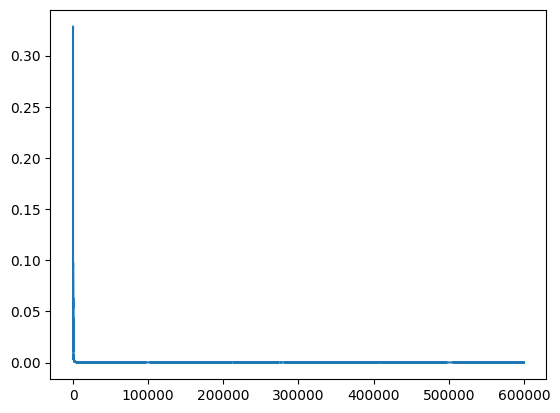

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

# Rendering the results

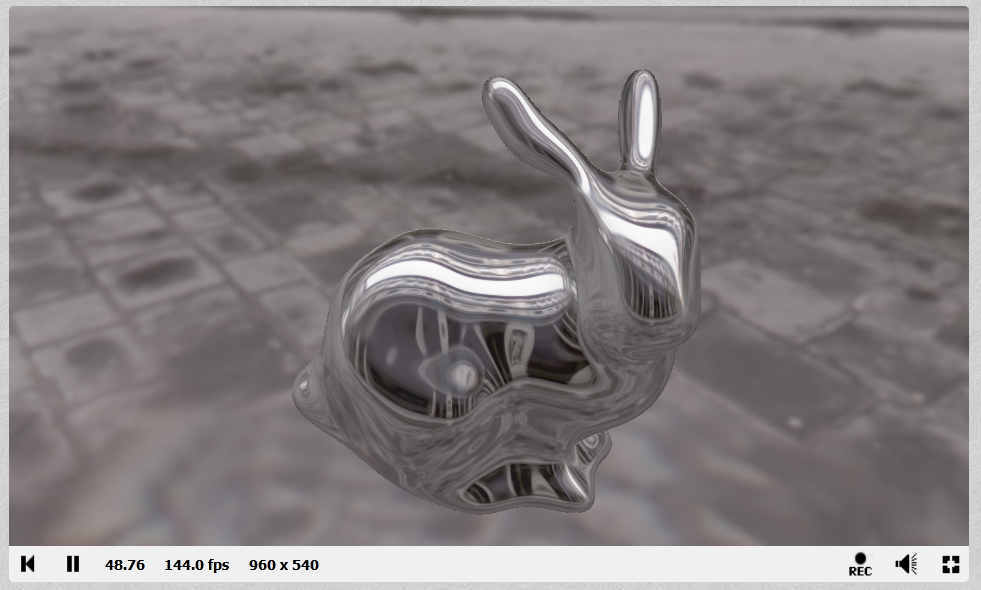

**We have learned a function, but what does it look like?**

Now that we have optimized the weights of our neural network, effectively we have obtained a new function that approximates a Signed Distance Field.
Using some helper functions, we can print the value of the weights and convert them in a [shading language](https://en.wikipedia.org/wiki/OpenGL_Shading_Language), a special programming language that GPUs can understand to display things. In this case, our Stanford Bunny!

There is a playground for graphics programming which is [ShaderToy](https://www.shadertoy.com/), that lets you run graphical programs directly from your browser.

To test it by yourself, execute the function `print_shader()`, copy the code, and in this [ShaderToy project](https://www.shadertoy.com/view/XXc3R4) replace the empty function `float nsdf(vec3 x)`.

Try to run different experiments, using both ReLU and Sigmoid activation functions. You will see different behaviors.

❗ **Note:** if you don't have a powerful graphics card, it is better to run the training with `model_size = small`.

In [ ]:
#@title #### Helper functions

def _vec4(v):
    return f"vec4({v[0]}, {v[1]}, {v[2]}, {v[3]})"


def _mat3x4(m):
    return f"mat3x4({_vec4(m[0])}, {_vec4(m[1])}, {_vec4(m[2])})"


def _mat4x4(m):
    return f"mat4x4({_vec4(m[0])}, {_vec4(m[1])}, {_vec4(m[2])}, {_vec4(m[3])})"


def _float(v):
    return f"{v}"


def _get_fourier_projection_statement(name, matrix, input_var, alpha):
    return f"vec4 {name} = {matrix} * {input_var} * {alpha};"


def _get_vec_projection_statement(name, matrix, input_var):
    return f"vec4 {name} = {matrix} * {input_var};"


def _get_dot_projection_statement(name, matrix, input_var):
    return f"float {name} = dot({matrix}, {input_var});"


def _get_activation_statement(name, input_var, activation_type="relu"):
    if activation_type == "relu":
        return f"vec4 {name} = max({input_var}, 0.0);"
    elif activation_type == "sigmoid":
        return f"vec4 {name} = 1.0f / (1.0f + exp(-({input_var})));"
    else:
        raise ValueError("Uncreognized activation type.")


def serialize_fourier_features(mapping, alpha, input_var, idx):
    # Return objects initialization.
    sin_vars, cos_vars = [], []
    statements = []

    output_submatrix_count = mapping.shape[1] // 4
    for o in range(output_submatrix_count):
        # Set up output variable names.
        sin_var_name = f"x_{idx}_{o}"
        cos_var_name = f"x_{idx}_{o + output_submatrix_count}"

        # Create matmul statement.
        m = mapping[:, o * 4 : (o + 1) * 4]  # 3x4
        projection = _get_fourier_projection_statement(
            f"x_e_{o}",
            _mat3x4(m),
            input_var,
            alpha * 2.0 * torch.pi,
        )
        sin_output = f"vec4 {sin_var_name} = sin(x_e_{o});"
        cos_output = f"vec4 {cos_var_name} = cos(x_e_{o});"

        # Update output vars.
        statements += [projection, sin_output, cos_output]
        sin_vars += [sin_var_name]
        cos_vars += [cos_var_name]

    # Concatenate sine and cosine output vars.
    output_vars = sin_vars + cos_vars
    return output_vars, statements


def serialize_4x4_layer(weight, bias, input_vars, idx, activation_type="relu"):
    # Return objects initialization.
    output_vars, statements = [], []

    output_submatrices_count = weight.shape[0] // 4
    for o in range(output_submatrices_count):
        submatrix_outputs = []
        for i, input_var in enumerate(input_vars):
            # Set up variable names.
            submatrix_output_name = f"x_{idx}_{o}_{i}"

            # Create matmul statement.
            m = weight[o * 4 : (o + 1) * 4, i * 4 : (i + 1) * 4]
            projection_statement = _get_vec_projection_statement(
                submatrix_output_name, _mat4x4(m.transpose(1, 0)), input_var
            )

            # Store outputs.
            statements += [projection_statement]
            submatrix_outputs += [submatrix_output_name]

        # Create activation statement.
        b = bias[o * 4 : (o + 1) * 4]
        pre_activation_sum = "+".join(submatrix_outputs + [_vec4(b)])
        output_name = f"x_{idx}_{o}"
        activation_statement = _get_activation_statement(
            output_name, pre_activation_sum, activation_type
        )

        # Store outputs.
        statements += [activation_statement]
        output_vars += [output_name]

    return output_vars, statements


def serialize_4x1_layer(weight, bias, input_vars, idx):
    # Return objects initialization.
    statements = []

    submatrix_outputs = []
    for i, input_var in enumerate(input_vars):
        # Set up variable names.
        submatrix_output_name = f"x_{idx}_0_{i}"

        # Create matmul statement.
        m = weight[0, i * 4 : (i + 1) * 4]
        projection = _get_dot_projection_statement(
            submatrix_output_name, _vec4(m), input_var
        )

        # Store outputs.
        statements += [projection]
        submatrix_outputs += [submatrix_output_name]

    # Create output sum statement.
    b = bias[0]
    output_sum = "+".join(submatrix_outputs + [_float(b)])
    output_name = f"x_{idx}"
    output_statement = f"float {output_name} = {output_sum};"

    statements += [output_statement]
    return [output_name], statements


def get_glsl_string(model):
    # Get lists of weights and biases.
    weights = [v.detach().numpy() for k, v in model.named_parameters() if "weight" in k]
    biases = [v.detach().numpy() for k, v in model.named_parameters() if "bias" in k]
    assert len(weights) == len(
        biases
    ), "Invalid model used. Number of weights and biases is not the same."

    # Set activation type from model.
    activation_type = None
    first_activation_layer = model.layers[2]
    if isinstance(first_activation_layer, torch.nn.ReLU):
        activation_type = "relu"
    elif isinstance(first_activation_layer, torch.nn.Sigmoid):
        activation_type = "sigmoid"
    else:
        raise ValueError("Invalid model used. Activation layer is not recognized.")

    # The input layer has to be FourierFeatures layer.
    fourier_layer = model.layers[0]
    assert isinstance(fourier_layer, FourierFeatures), "Invalid model used."
    fourier_mapping = fourier_layer.fourier_mappings
    fourier_alpha = fourier_layer.alpha

    statements = []
    module_idx = 0

    # Generate code for FourierFeatures layer.
    output_vars, stmts = serialize_fourier_features(
        fourier_mapping, fourier_alpha, "x", module_idx
    )
    module_idx += 1
    statements += stmts

    # Generate code for hidden layers.
    for w, b in zip(weights[:-1], biases[:-1]):
        output_vars, stmts = serialize_4x4_layer(
            w, b, output_vars, module_idx, activation_type
        )
        module_idx += 1
        statements += stmts

    # Generate code for the output layer.
    output_vars, stmts = serialize_4x1_layer(
        weights[-1], biases[-1], output_vars, module_idx
    )
    statements += stmts

    # Return statement.
    return_statement = f"return {output_vars[0]};"
    statements += [return_statement]

    return statements


def print_shader():
    parser = argparse.ArgumentParser(
        description="Script to convert an SDF model to GLSL code.."
    )
    parser.add_argument("model", help="Model to convert an SDF model to GLSL.")
    parser.add_argument(
        "--separate_lines",
        action="store_true",
        help="If specified, each statement will be put on a separate line.",
    )

    model = torch.load(OUTPUT).cpu()
    statements = get_glsl_string(model)

    separator = "\n    "

    print("float nsdf(vec3 x) {")
    print("    " + separator.join(statements))
    print("}")

In [ ]:
print_shader()

float nsdf(vec3 x) {
    vec4 x_e_0 = mat3x4(vec4(0.2069620043039322, -1.6356239318847656, 0.8217518925666809, 0.1108493059873581), vec4(1.1069715023040771, 0.2891674041748047, -0.10580070316791534, 1.38664710521698), vec4(0.22999076545238495, -0.6544011235237122, 1.6361130475997925, -0.5366798043251038)) * x * 2.457695245742798;
    vec4 x_0_0 = sin(x_e_0);
    vec4 x_0_4 = cos(x_e_0);
    vec4 x_e_1 = mat3x4(vec4(-0.5057519674301147, -0.7527872323989868, -1.4506672620773315, 0.013758537359535694), vec4(0.43312448263168335, 0.4549684226512909, -0.008288840763270855, -1.1928681135177612), vec4(0.5924518704414368, -0.03501389920711517, -0.005508378613740206, 0.6274693012237549)) * x * 2.457695245742798;
    vec4 x_0_1 = sin(x_e_1);
    vec4 x_0_5 = cos(x_e_1);
    vec4 x_e_2 = mat3x4(vec4(0.04939449205994606, 1.4668786525726318, -0.16958941519260406, 0.5163582563400269), vec4(1.6319185495376587, 0.8307983875274658, -0.3202987313270569, 0.33674362301826477), vec4(-0.6603466272354126, 2.0

# References
- Big thanks to the NSDF Repository https://github.com/janivanecky/nsdf
- Fourier Features https://arxiv.org/abs/2006.10739
- DeepSDF https://arxiv.org/abs/1901.05103